# Text Classification - Deep Learning Sequential Models - LSTMs


Another new and interesting approach to supervised deep learning is the use
of recurrent neural networks (RNNs) and long short-term memory networks (LSTMs)
which also considers the sequence of data (words, events and so on). These are more
advanced models than your regular fully connected deep networks and usually take
more time to train.


In [2]:
!nvidia-smi

Wed May 27 20:35:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 245kB 6.9MB/s 
     |████████████████████████████████| 317kB 56.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81702 sha256=937e8cc73939b640784216d708230bbf1f4e9f7a924d01ba42cd0f061ca0652c
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [5]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [0]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [9]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:06<00:00, 2366.05it/s]

CPU times: user 21 s, sys: 115 ms, total: 21.2 s
Wall time: 21.1 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [0]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [11]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175859), ('<PAD>', 0), 1)

In [0]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [13]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175860
Number of Documents=35000


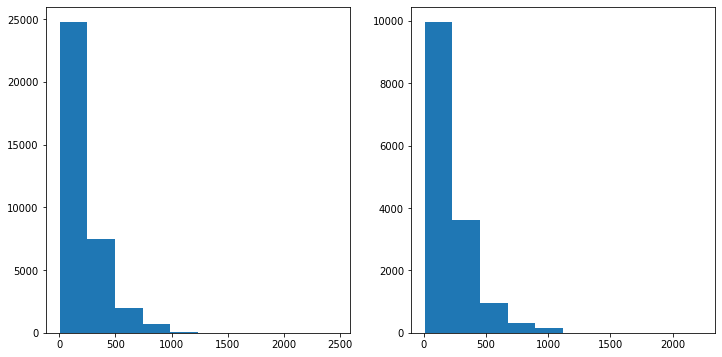

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [0]:
MAX_SEQUENCE_LENGTH = 1000

In [16]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [0]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [0]:
VOCAB_SIZE = len(t.word_index)

# LSTM Model

# Build Model Architecture


# Embeddings

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words. 

![](https://i.imgur.com/WuV47DW.png)


# LSTM

LSTMs try to overcome
the shortcomings of RNN models, especially with regard to handling long-term
dependencies and problems that occur when the weight matrix associated with the
units (neurons) become too small (leading to vanishing gradient) or too large (leading to
exploding gradient). These architectures are more complex than regular deep networks
and going into detailed internals and math concepts are out of the current scope, but we
will try to cover the essentials here without making it math heavy

![](https://i.imgur.com/c8qGKX8.png)

The sequence of operations in the LSTM cell is briefly shown as follows.

![](https://i.imgur.com/uiIbDk1.png)

In [23]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 300)         52758000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 53,010,929
Trainable params: 53,010,929
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [24]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 151s 611ms/step - loss: 0.4077 - accuracy: 0.8127 - val_loss: 0.4319 - val_accuracy: 0.7954
Epoch 2/10
247/247 [==============================] - 152s 614ms/step - loss: 0.1864 - accuracy: 0.9312 - val_loss: 0.3629 - val_accuracy: 0.8817
Epoch 3/10
247/247 [==============================] - 147s 596ms/step - loss: 0.0879 - accuracy: 0.9690 - val_loss: 0.4088 - val_accuracy: 0.8574
Epoch 4/10
247/247 [==============================] - 148s 599ms/step - loss: 0.0585 - accuracy: 0.9800 - val_loss: 0.5659 - val_accuracy: 0.8549
Epoch 00004: early stopping


## Evaluate Model Performance

In [25]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 13s 27ms/step - loss: 0.3475 - accuracy: 0.8855
Accuracy: 88.55%


In [26]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [27]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive']

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.90      0.86      0.88      7490
    positive       0.87      0.91      0.89      7510

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



,negative,positive
negative,6464,1026
positive,692,6818


# Stacked LSTM Model

## Build Model Architecture

In [35]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 300)         52758000  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 128)         219648    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 53,142,513
Trainable params: 53,142,513
Non-trainable params: 0
__________________________________________

## Train Model

In [36]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es],
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 169s 683ms/step - loss: 0.4110 - accuracy: 0.8120 - val_loss: 0.3208 - val_accuracy: 0.8703
Epoch 2/10
247/247 [==============================] - 164s 666ms/step - loss: 0.1577 - accuracy: 0.9452 - val_loss: 0.3205 - val_accuracy: 0.8786
Epoch 3/10
247/247 [==============================] - 163s 660ms/step - loss: 0.0734 - accuracy: 0.9754 - val_loss: 0.4807 - val_accuracy: 0.8663
Epoch 4/10
247/247 [==============================] - 163s 659ms/step - loss: 0.0950 - accuracy: 0.9676 - val_loss: 0.4461 - val_accuracy: 0.8417
Epoch 00004: early stopping


## Evaluate Model Performance

In [37]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 20s 43ms/step - loss: 0.3084 - accuracy: 0.8850
Accuracy: 88.50%


In [38]:
predictions = model2.predict_classes(X_test).ravel()
predictions[:10]

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [39]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [40]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      7490
    positive       0.88      0.89      0.89      7510

    accuracy                           0.89     15000
   macro avg       0.89      0.88      0.88     15000
weighted avg       0.89      0.89      0.88     15000



,negative,positive
negative,6587,903
positive,822,6688
